Names: Fabio Lenherr & Kaj Habegger

## Import required libraries

In [ ]:
! pip install tensorflow
! pip install matplotlib

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [17]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sklearn for Confusion Matrix
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.10.1


In [2]:
# Check whether GPU is available for ML or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

In [3]:
train_dir = 'datasets/dataset_training/'
test_dir = 'datasets/dataset_testing/'
batch_size = 32
img_height = 256
img_width = 256

training_ds, validation_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
    subset="both",
    seed=24,
    validation_split=0.2
)


testing_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)

Found 16276 files belonging to 11 classes.
Using 13021 files for training.
Using 3255 files for validation.
Found 9979 files belonging to 11 classes.


## Data information and visualization

In [4]:
class_names = training_ds.class_names
num_classes = len(training_ds.class_names)
print(class_names)

['bug', 'electric', 'fire', 'fly', 'grass', 'ground', 'normal', 'poison', 'psychic', 'rock', 'water']


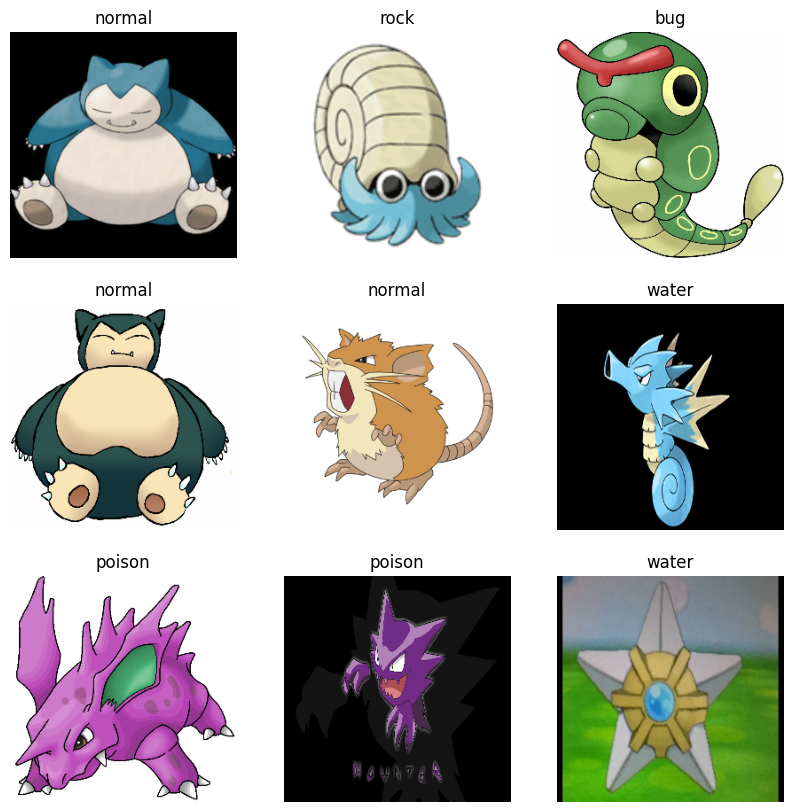

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# Shape of each Batch
for image_batch, labels_batch in training_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

# Dataset.prefetch overlaps data preprocessing and model execution while training

## Underfitted Model

In [8]:
underfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(4, 64, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes)
])

In [9]:
underfitted_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [10]:
num_epochs=10

underfitted_history = underfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/10
407/407 [==============================] - 43s 96ms/step - loss: 2.4123 - acc: 0.2059 - val_loss: 2.3344 - val_acc: 0.2126
Epoch 2/10
407/407 [==============================] - 37s 90ms/step - loss: 2.2791 - acc: 0.2281 - val_loss: 2.3130 - val_acc: 0.2163
Epoch 3/10
407/407 [==============================] - 36s 89ms/step - loss: 2.2033 - acc: 0.2481 - val_loss: 2.3511 - val_acc: 0.2243
Epoch 4/10
407/407 [==============================] - 36s 89ms/step - loss: 2.1379 - acc: 0.2713 - val_loss: 2.4077 - val_acc: 0.2264
Epoch 5/10
407/407 [==============================] - 36s 90ms/step - loss: 2.0836 - acc: 0.2895 - val_loss: 2.4858 - val_acc: 0.2267
Epoch 6/10
407/407 [==============================] - 37s 90ms/step - loss: 2.0443 - acc: 0.3017 - val_loss: 2.5588 - val_acc: 0.2313
Epoch 7/10
407/407 [==============================] - 37s 90ms/step - loss: 2.0116 - acc: 0.3134 - val_loss: 2.6525 - val_acc: 0.2326
Epoch 8/10
407/407 [==============================] - 36s 89ms

In [11]:
underfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 193, 193, 4)       49156     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 4)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 11)                405515    
                                                                 
Total params: 454,671
Trainable params: 454,671
Non-trainable params: 0
__________________________________________________

In [12]:
acc = underfitted_history.history['acc']
val_acc = underfitted_history.history['val_acc']
loss = underfitted_history.history['loss']
val_loss = underfitted_history.history['val_loss']

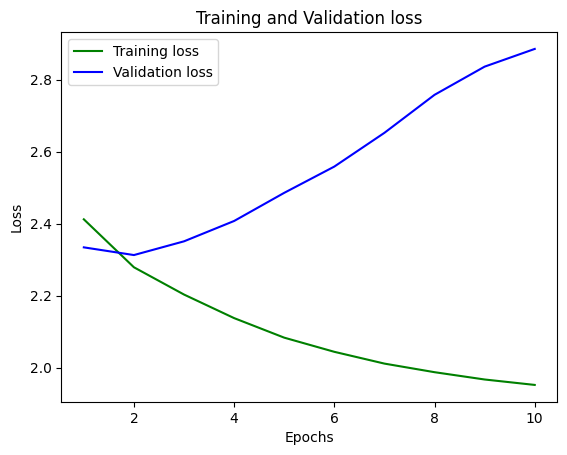

In [14]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

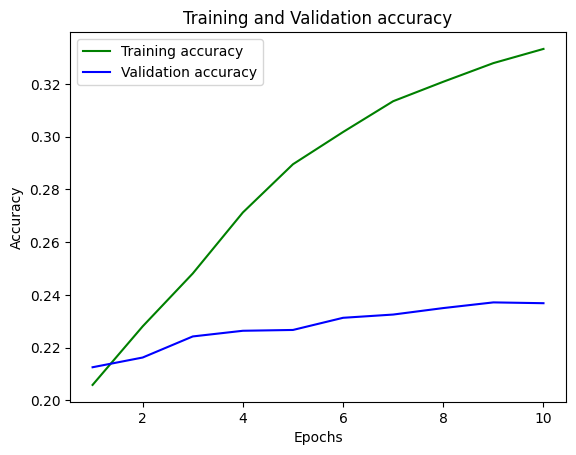

In [15]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = underfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 620ms/step


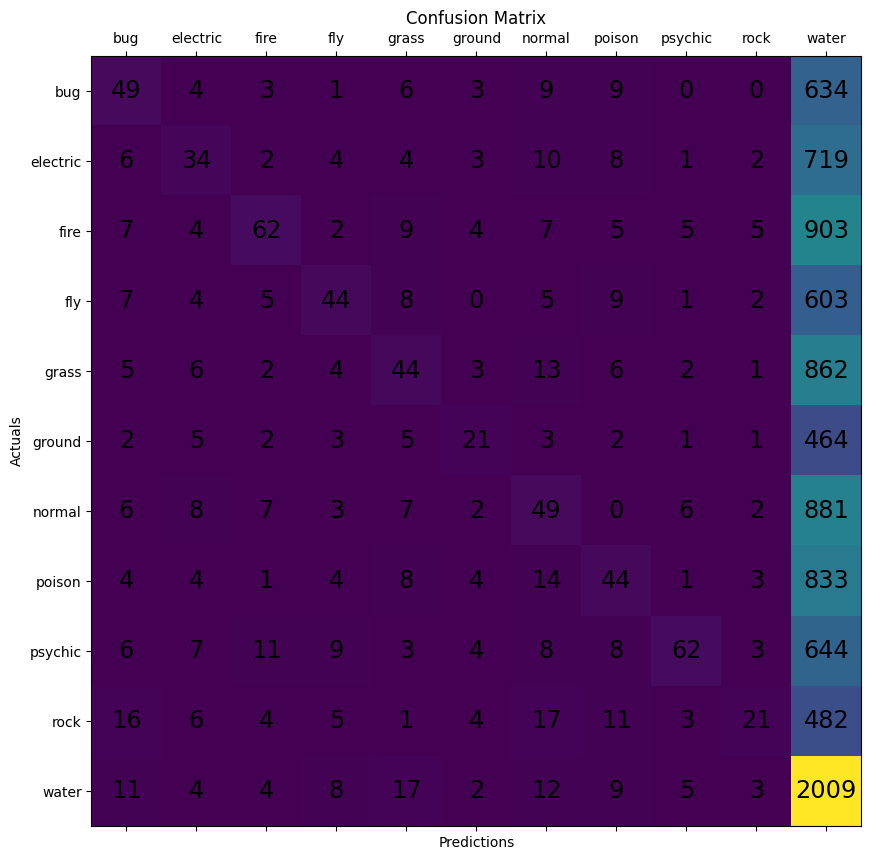

In [19]:
conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix)

ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## Overfitted Model

In [7]:
overfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [8]:
overfitted_model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [9]:
num_epochs=50

overfitted_history = overfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/50


C:\Users\Kaj\miniconda3\envs\aiap\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


407/407 [==============================] - 40s 85ms/step - loss: 1.7752 - acc: 0.4270 - val_loss: 1.4489 - val_acc: 0.5321
Epoch 2/50
407/407 [==============================] - 30s 75ms/step - loss: 1.1474 - acc: 0.6257 - val_loss: 1.2061 - val_acc: 0.6258
Epoch 3/50
407/407 [==============================] - 31s 75ms/step - loss: 0.7694 - acc: 0.7565 - val_loss: 1.3350 - val_acc: 0.6363
Epoch 4/50
407/407 [==============================] - 31s 75ms/step - loss: 0.4856 - acc: 0.8441 - val_loss: 1.5562 - val_acc: 0.6375
Epoch 5/50
407/407 [==============================] - 31s 75ms/step - loss: 0.2972 - acc: 0.9035 - val_loss: 1.9346 - val_acc: 0.6528
Epoch 6/50
407/407 [==============================] - 31s 75ms/step - loss: 0.1881 - acc: 0.9379 - val_loss: 2.3888 - val_acc: 0.6430
Epoch 7/50
407/407 [==============================] - 31s 75ms/step - loss: 0.1510 - acc: 0.9511 - val_loss: 2.3258 - val_acc: 0.6427
Epoch 8/50
407/407 [==============================] - 31s 75ms/step - los

In [10]:
overfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       2

In [11]:
acc = overfitted_history.history['acc']
val_acc = overfitted_history.history['val_acc']
loss = overfitted_history.history['loss']
val_loss = overfitted_history.history['val_loss']

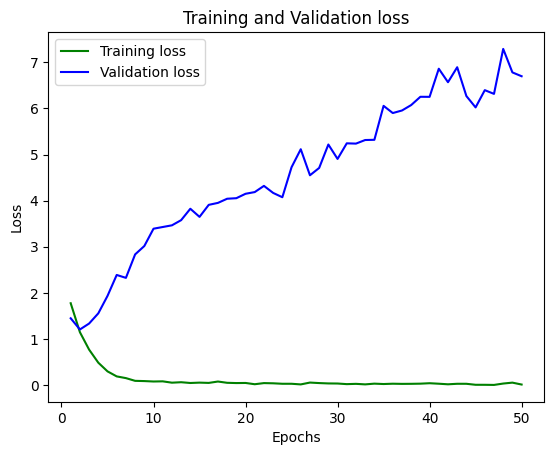

In [16]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

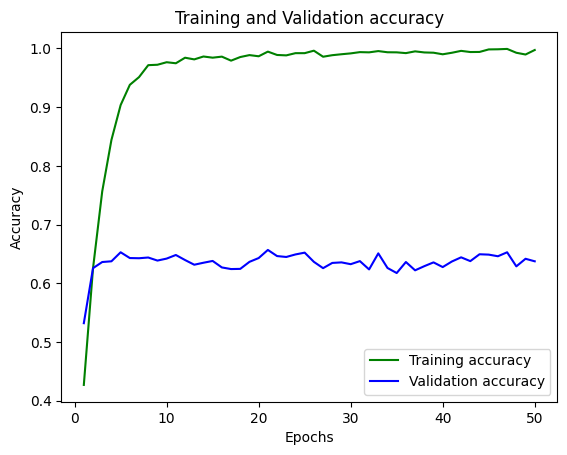

In [15]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Optimized Model

## Prediction

In [17]:
probability_model = tf.keras.Sequential([overfitted_model, 
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(testing_ds)

312/312 [==============================] - 10s 30ms/step


In [19]:
predictions[0]

array([0.07862698, 0.07862698, 0.07862698, 0.07862698, 0.21373025,
       0.07862698, 0.07862698, 0.07862698, 0.07862698, 0.07862698,
       0.07862698], dtype=float32)

In [20]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(11))
  plt.yticks([])
  thisplot = plt.bar(range(11), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


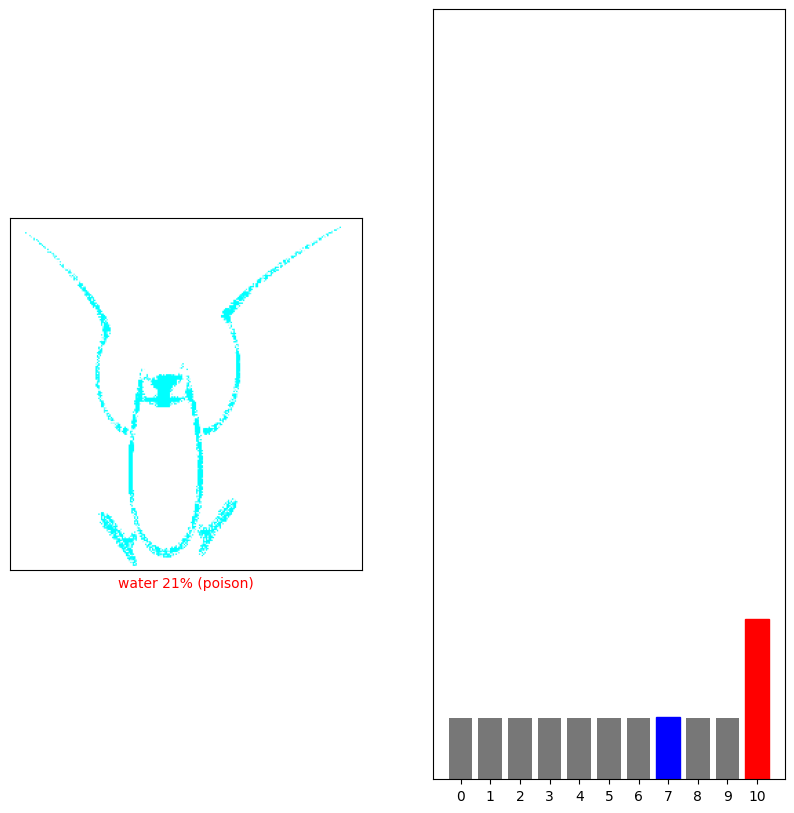

In [24]:
i = 10
ds = testing_ds

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
#for images, labels in test_ds.take(1):
iterator = iter(ds)
image, labels = next(iterator)
plot_image(i, predictions[i], labels, image)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels)
plt.show()